# Mounting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/My Drive/...

# Data Preparation

## Libraries and Reading the 

### Libraries

In [ ]:
!pip install shap

In [ ]:
import warnings

from google.cloud import bigquery
import pandas_gbq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from scipy import stats
import scipy.stats as ss
#import chart_studio.plotly as py
import json
from matplotlib import mlab
import os
from pandas_profiling import ProfileReport
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import mannwhitneyu # is for independent samples. For related / paired samples, consider

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
from lightgbm import LGBMRegressor
import lightgbm as lgb


from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from itertools import product
from IPython.display import clear_output
import shap


%matplotlib inline

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")


### Functions

In [ ]:
def know_your_data(data):
    print('Head: {}'.format(data.ndim))
    print('Shape: {}'.format(data.shape))
    print('Length: {}'.format(data.size))
    print('Columns: {}'.format(data.columns))
    print("-----------------------------------")
    print('Types: {}'.format(data.dtypes))
    print("-----------------------------------")
    print("Nullity Check:\n", pd.isnull(data).any())
    print("Percentage of Null Instances: {}".format(df.isnull().sum() * 100 / len(df)))


def show_hist_plot(df,column_name):
    fig1 = px.histogram(df, x=column_name, color_discrete_sequence=['indianred'], histnorm='percent')
    yaxis=dict(ticksuffix=".00%")

    fig1.update_layout(
       title="Histogram of Number of {}".format(column_name),
        xaxis_title=column_name,
        yaxis_title="Percentage",yaxis=dict(ticksuffix=".00%") )
    fig1.show()

def convert_per_listening_time_to_one(df):
    df['per_listening_time']=df['raw_per_listening_time']
    mask = (df['raw_per_listening_time'] > 1.00) 
    df['per_listening_time'][mask] = 1.00  
    
def create_cum_perc_df(df, column_name):  
    df_counted = df.value_counts([column_name]).rename_axis('unique_values').reset_index(name='counts')
    df_counted['count_running_total'] = df_counted['counts'].cumsum()
    df_counted['percent_of_total'] = df_counted['count_running_total']/df_counted['counts'].sum()*100
    return df_counted  


def have_cum_graph(df,column_name,title, x_label):
    
    df_counted = create_cum_perc_df(df, column_name)
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_counted['unique_values'], y=df_counted['percent_of_total'],
                        mode='lines+markers'))
    fig.update_layout(title= title,
                   xaxis_title= x_label,
                   yaxis_title='Percent of the tracks listened')
    fig.show()  
    

def convert_per_listening_time_to_one(df):
    df['per_listening_time']=df['raw_per_listening_time']
    mask = (df['raw_per_listening_time'] > 1.00) 
    df['per_listening_time'][mask] = 1.00
    
def get_part_of_day(df):
    b = [0,4,8,12,16,20,24]
    l = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']
    df['part_of_day'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)
    
def get_day_month(df): 
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['day_of_week'] = df['date'].dt.day_name()
    df['hour']=df['date'].dt.hour
    
    
def convert_strings_to_datetime(df): 
    df['date'] = pd.to_datetime(df['ts'],unit='s')
    df['track_upload_date'] = pd.to_datetime(df['track_upload_date'],unit='s')
    df['listener_signup_date'] = pd.to_datetime(df['listener_signup_date'],unit='s')

def convert_milliseconds_to_mins(df): 
    df['track_duration_minutes'] = df['track_duration'].div(60000).round(2)
    df['listen_duration_minutes'] = df['listen_duration'].div(60000).round(2)
    df['listener_prev_month_listening_time_minutes'] = df['listener_prev_month_listening_time'].div(60000).round(2)

def stacked_bar_chart_combined_columns(df,grouped_column_1,grouped_column_2,group_column):
    freq_df = df.groupby([grouped_column_1,grouped_column_2])[group_column].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    return pct_df.plot(kind="bar", stacked=True,figsize=(17,8))

def stacked_bar_chart(df,grouped_column,group_column):
    freq_df = df.groupby([grouped_column])[group_column].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    return pct_df.plot(kind="bar", stacked=True,figsize=(17,8))


  

def create_violin_plot(df,column_1,column_2):
    fig = go.Figure(data=go.Violin(y=df[column_1], box_visible=True, line_color='black',
                                   meanline_visible=True, fillcolor='lightseagreen', opacity=0.6,
                                   x0='all data'))

    fig.update_layout(yaxis_zeroline=False)

    list_column_2=list(df[column_2].unique())

    for i in list_column_2:
        fig.add_trace(go.Violin(x=df[column_2][df[column_2] == i],
                                y=df[column_1][df[column_2] == i],
                                name=i,
                                box_visible=True,
                                meanline_visible=True))

    fig.show()
    



def get_basic_bar_chart(df,column):
  s_counted=df[column].value_counts()
  df_counted=pd.DataFrame({'labels':s_counted.index, 'count':s_counted.values})
  df_counted['percentage'] = (df_counted['count'] / df_counted['count'].sum()) * 100
  df_counted.plot(kind='bar', x='labels', y='percentage')


def CheckingCorrelations(df,colorstyle):

    column_names=df.columns 
    num = len(column_names)
    correlations = df[column_names].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap=colorstyle)  
    fig.colorbar(cax)
    ticks = np.arange(0, num, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(column_names)
    ax.set_yticklabels(column_names)
    ax.tick_params(labelsize=13)
    plt.show()
    

    

def cramers_v(df,column_1,column_2):
    
    """ calculate Cramers V statistic for categorial-categorial association.    

        𝑉∈[0.1,0.3]: weak association
        𝑉∈[0.4,0.5]: medium association
        𝑉>0.5: strong association
             
    """
    confusion_matrix = pd.crosstab(df[column_1], df[column_2])
    confusion_matrix=confusion_matrix.values
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v =np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    if cramers_v <= 0.3:
      strength='weak'
    elif cramers_v <= 0.5:
      strength='medium'
    else:          
      strength='strong'
    print(column_1,' & ',column_2, "==> cramers_v score is:", cramers_v)
    print("strength of association is:", strength)
    
def get_relation(df, column_1, column_2):
    do_chi_square_test(df,column_1,column_2)
    print('---------------------------------------------------------------')
    cramers_v(df,column_1, column_2) 

def check_variance_mean_diff_of_per_listening_time(column,value_1,value_2):
    alpha = 0.05

    list_1= list(df[df[column]==value_1]['per_listening_time'])
    list_2= list(df[df[column]==value_2]['per_listening_time'])

    result_levene=stats.levene(list_1, list_2)
    conclusion_levene = "Failed to reject the null hypothesis.(There is no diff in the variances)"
    if result_levene.pvalue > alpha:
        conclusion_levene = "Null Hypothesis (There is no diff in the variances) is rejected."

    result_mannwhitneyu=mannwhitneyu(list_1, list_2) 
    conclusion_mannwhitneyu = "Failed to reject the null hypothesis.(There is no diff in the means)"
    if result_mannwhitneyu.pvalue > alpha:
        conclusion_mannwhitneyu = "Null Hypothesis (There is no diff in the means) is rejected."

    print('Check if ',value_1,' & ',value_2, ' have equal variances')
    print(result_levene)
    print(conclusion_levene)
    print('----------------------------------------')
    print('Check if there is significant difference between the means of ',value_1,' & ',value_2 )
    print(result_mannwhitneyu)
    print(conclusion_mannwhitneyu)

def create_box_violin_plots(df,column):
    fig = go.Figure()

    fig.add_trace(go.Violin(y=df[column], box_visible=True, line_color='black',
                                       meanline_visible=True, fillcolor='gold', opacity=0.6,name=column)
                 )
    fig.add_trace(go.Box(y=df[column],name = column,
                    marker_color = 'darkgoldenrod'))

    fig.show()


def show_hist_plot(df,column_name, color_discrete_sequence='indianred'):
    fig1 = px.histogram(df, x=column_name, color_discrete_sequence=[color_discrete_sequence], histnorm='percent')
    yaxis=dict(ticksuffix="%")

    fig1.update_layout(
       title="Histogram of Number of {}".format(column_name),
        xaxis_title=column_name,
        yaxis_title="Percentage",yaxis=dict(ticksuffix="%") )
    fig1.show()


def remove_outlier_z_score_detection_median(column_name, df):
    df = df.reset_index(drop=True)
    threshold = 3 #this means 3 standard deviations
    var_median = np.median(df[column_name])
    var_sd = np.std(df[column_name])
    z_scores = [(i - var_median)/var_sd for i in df[column_name]]
    indexes = np.where(np.abs(z_scores) > threshold)[0] #array
    dataframe = df.drop(indexes,axis=0) 
    return dataframe

def remove_outlier_z_score_detection_mean(df,column_name):
    df = df.reset_index(drop=True)
    threshold = 3 #this means 3 standard deviations
    var_mean = np.mean(df[column_name])
    var_sd = np.std(df[column_name])
    z_scores = [(i - var_mean)/var_sd for i in df[column_name]]
    indexes = np.where(np.abs(z_scores) > threshold)[0]
    dataframe = df.drop(indexes)
    return dataframe

def create_basic_violin_plot(df,column):

  fig = go.Figure(data=go.Violin(y=df[column], box_visible=True, line_color='black',
                                meanline_visible=True, fillcolor='lightseagreen', opacity=0.6,
                                x0=column))

  fig.update_layout(yaxis_zeroline=False)
  fig.show()

def do_chi_square_test(df,column_1,column_2):


    # create contingency table
    data_crosstab = pd.crosstab(df[column_1],
                                df[column_2],
                                margins=True, margins_name="Total")
    # significance level
    alpha = 0.05

    # Calcualtion of Chisquare test statistics
    chi_square = 0
    rows = df[column_1].unique()
    columns = df[column_2].unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E

    # The p-value approach
    print("The p-value approach to hypothesis testing in the decision rule")
    p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis (no relation between variables) is rejected."
    #return (p_value,conclusion)
    print(column_1,' & ',column_2, "==> chisquare-score is:", chi_square, " and p value is:", p_value)
    print(conclusion)

def get_table(df, column_1,column_2):  
    freq_df = df.groupby([column_1,column_2])['is_skipped'].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    pct_df=pct_df.reset_index()             
    pct_df.drop(columns=['False',],inplace=True)
    pct_df=round(pct_df.pivot_table('True', column_1,column_2, fill_value=0),2)
    return pct_df

### Reading the data

In [ ]:
#path = f'/Users/b.oeniz/Documents/sc_data_science_challenge.json'
#os.chdir('/Users/b.oeniz/Documents')

# Reading the json as a dict
with open('sc_data_science_challenge.json') as json_data:
    data = json.load(json_data)
type(data)


json_obj=json.load(open('sc_data_science_challenge.json'))
df_raw=pd.DataFrame(json_obj['data'],columns=json_obj['columns'])

## Data Manipulation

In [ ]:
#all the data manipulations, please run this chunk to have the final data

df=df_raw.copy()

df = df.astype(dtype={'listener_id': 'string','country_code': 'string'})
df.convert_dtypes()

df.drop_duplicates(inplace=True)
df.duplicated().any()
df = df.drop(df[(df['listen_duration'] < 0)].index)
df.dropna(inplace=True)
df = df.replace('None', np.nan).dropna(how='all')

convert_strings_to_datetime(df)
convert_milliseconds_to_mins(df)
get_day_month(df)
get_part_of_day(df)
df["day_of_week+part_of_day"] = df["day_of_week"].astype(str)  + df["part_of_day"].astype(str) 

df["raw_per_listening_time"] = round(df["listen_duration_minutes"]/df["track_duration_minutes"],2)


#dropping the inf numbers
with pd.option_context('mode.use_inf_as_na', True):
    df = df.dropna(subset=['raw_per_listening_time'], how='all')
pd.set_option('use_inf_as_na', True)

    
convert_per_listening_time_to_one(df)

df = df.drop(df[(df['listen_duration'] < 0)].index)

df = df.drop(df[(df['per_listening_time'] < 0.00)].index)


def define_skipping(listen_duration_minutes,track_genre_category,per_listening_time):

    if track_genre_category == 'Speech':
        if listen_duration_minutes > 5:
            return False
        elif per_listening_time > 0.3:
            return False
        else:
            return True
    else:
        if listen_duration_minutes > 3:
            return False
        elif per_listening_time > 0.3:
            return False
        else:
            return True

df['is_skipped'] = df.apply(lambda x: define_skipping(x['listen_duration_minutes'],x['track_genre_category'],x['per_listening_time']),axis=1)



perc_type = []

for i in df['per_listening_time']:
    if i <= 0.69:
        perc_type.append('medium')
    elif i <= 0.95:
        perc_type.append('high')
    else:
        perc_type.append('complete')
        
        
        
df['percentage_type'] = perc_type
  
list_is_listener_signup_date = []
list_user_type = []

for index, row in df.iterrows():
    if row['date'] == row['listener_signup_date']:
        list_is_listener_signup_date.append('True')
        list_user_type.append('new user')
    else:
        list_is_listener_signup_date.append('False')
        list_user_type.append('returning user')

        
df['is_listener_signup_date'] = list_is_listener_signup_date
df['user_type'] = list_user_type

list_is_track_old = []

for index, row in df.iterrows():
    if abs((row['date'] - row['track_upload_date']).days) > 365 :
        list_is_track_old.append('True')
    else:
        list_is_track_old.append('False')
       

df['is_track_old'] = list_is_track_old


df = remove_outlier_z_score_detection_median('listen_duration_minutes', df)



list_is_same_genre = []

for index, row in df.iterrows():
    if row['track_genre_category'] == row['listener_top_genre_category_listened']:
        list_is_same_genre.append('True')
    else:
        list_is_same_genre.append('False')

df['is_same_genre'] = list_is_same_genre


# Separeting Categorical and Integer Columns

In [ ]:
df

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened,date,track_duration_minutes,listen_duration_minutes,listener_prev_month_listening_time_minutes,month,day,day_of_week,hour,part_of_day,day_of_week+part_of_day,raw_per_listening_time,per_listening_time,is_skipped,percentage_type,is_listener_signup_date,user_type,is_track_old,is_same_genre
0,1467398683,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,2016-06-23,413933,413933,0001d5755511cae40e5b32d83a3decce,2011-12-25,HipHop & R&B,617270940.0,22.5,2016-07-01 18:44:43,6.90,6.90,10287.85,7,1,Friday,18,Evening,FridayEvening,1.00,1.00,False,complete,False,returning user,False,False
1,1467398924,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,2016-06-24,402640,110722,0001d5755511cae40e5b32d83a3decce,2011-12-25,HipHop & R&B,617270940.0,22.5,2016-07-01 18:48:44,6.71,1.85,10287.85,7,1,Friday,18,Evening,FridayEvening,0.28,0.28,True,medium,False,returning user,False,True
2,1467820636,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,2016-06-28,494811,193818,0001d5755511cae40e5b32d83a3decce,2011-12-25,HipHop & R&B,617270940.0,22.5,2016-07-06 15:57:16,8.25,3.23,10287.85,7,6,Wednesday,15,Noon,WednesdayNoon,0.39,0.39,False,medium,False,returning user,False,False
3,1467401951,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,2014-06-09,361585,361585,000264c5b34ad04999535c8b6a8b86e2,2013-09-17,HipHop & R&B,112239180.0,10.5,2016-07-01 19:39:11,6.03,6.03,1870.65,7,1,Friday,19,Evening,FridayEvening,1.00,1.00,False,complete,False,returning user,True,True
4,1467402159,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,2015-11-28,373700,160162,000264c5b34ad04999535c8b6a8b86e2,2013-09-17,HipHop & R&B,112239180.0,10.5,2016-07-01 19:42:39,6.23,2.67,1870.65,7,1,Friday,19,Evening,FridayEvening,0.43,0.43,False,medium,False,returning user,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759494,1469210707,GB,204.0.20,tracks,content-based,fa1bee861803edd9268155248cd6fdf2,Pop,2011-05-28,376736,376736,fffb75094c16845d971945a7ecd6f061,2014-11-24,Pop,187040400.0,4.5,2016-07-22 18:05:07,6.28,6.28,3117.34,7,22,Friday,18,Evening,FridayEvening,1.00,1.00,False,complete,False,returning user,True,True
759495,1469210923,US,204.0.20,tracks,content-based,4d8f6a272b154ec0b18094170af77558,Classical,2010-12-24,332924,332924,fffb75094c16845d971945a7ecd6f061,2014-11-24,Pop,187040400.0,4.5,2016-07-22 18:08:43,5.55,5.55,3117.34,7,22,Friday,18,Evening,FridayEvening,1.00,1.00,False,complete,False,returning user,True,False
759496,1469211113,US,204.0.20,tracks,content-based,2582fb7e7506552645165734de8da733,Classical,2014-09-09,324144,324144,fffb75094c16845d971945a7ecd6f061,2014-11-24,Pop,187040400.0,4.5,2016-07-22 18:11:53,5.40,5.40,3117.34,7,22,Friday,18,Evening,FridayEvening,1.00,1.00,False,complete,False,returning user,True,False
759497,1469211300,GB,204.0.20,tracks,content-based,4f38b30c8e4d151c20ac71e9ddf0fbef,Pop,2013-01-03,269325,269325,fffb75094c16845d971945a7ecd6f061,2014-11-24,Pop,187040400.0,4.5,2016-07-22 18:15:00,4.49,4.49,3117.34,7,22,Friday,18,Evening,FridayEvening,1.00,1.00,False,complete,False,returning user,True,True


In [ ]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.drop(columns=['per_listening_time'],inplace=True)
num_cols=df_num.columns
num_cols

Index(['ts', 'track_duration', 'listen_duration',
       'listener_prev_month_listening_time',
       'listener_prev_month_avg_daily_tracks_listened',
       'track_duration_minutes', 'listen_duration_minutes',
       'listener_prev_month_listening_time_minutes', 'month', 'day', 'hour',
       'raw_per_listening_time'],
      dtype='object')

In [ ]:
quantitative_features_list=list(df_num.columns)
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.drop(columns=['per_listening_time','track_upload_date'],inplace=True)
cat_cols=df_categ.columns
cat_cols

Index(['country_code', 'client_version', 'listening_context',
       'recommender_algorithm_name', 'track_id', 'track_genre_category',
       'listener_id', 'listener_signup_date',
       'listener_top_genre_category_listened', 'date', 'day_of_week',
       'part_of_day', 'day_of_week+part_of_day', 'raw_per_listening_time',
       'is_skipped', 'percentage_type', 'is_listener_signup_date', 'user_type',
       'is_track_old', 'is_same_genre'],
      dtype='object')

In [ ]:
print('number of numerical features: ', len(df_num.columns))
print('number of categorical features: ', len(df_categ.columns))

number of numerical features:  12
number of categorical features:  20


In [ ]:
label_col = 'per_listening_time'

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder


# ------------------------------------- LightGBM Regression -------------------------------------

## Data Prepation

In [ ]:
data = df.drop(columns=['ts','raw_per_listening_time','track_id','is_skipped','percentage_type','date','country_code','client_version','listener_id','listener_signup_date','track_upload_date','track_duration_minutes','listen_duration_minutes'])

In [ ]:
import gc
gc.enable()

In [ ]:
y = data['per_listening_time']
X = data.drop(['per_listening_time'], axis=1)

del data
gc.collect()

252

In [ ]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751180 entries, 0 to 759498
Data columns (total 19 columns):
 #   Column                                         Non-Null Count   Dtype   
---  ------                                         --------------   -----   
 0   listening_context                              751180 non-null  category
 1   recommender_algorithm_name                     751180 non-null  category
 2   track_genre_category                           751180 non-null  category
 3   track_duration                                 751180 non-null  int64   
 4   listen_duration                                751180 non-null  int64   
 5   listener_top_genre_category_listened           751180 non-null  category
 6   listener_prev_month_listening_time             751180 non-null  float64 
 7   listener_prev_month_avg_daily_tracks_listened  751180 non-null  float64 
 8   listener_prev_month_listening_time_minutes     751180 non-null  float64 
 9   month                     

## Prep for the Model

### Split the full sample into train/test (95/05)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=314, stratify=y)

In [ ]:
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto',
            'categorical_feature': 'auto' 
           }

## Models

### The First Model

In [ ]:
clf = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

In [ ]:
clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.992919
[200]	valid's auc: 0.995924
[300]	valid's auc: 0.997536
[400]	valid's auc: 0.998175
[500]	valid's auc: 0.998559
[600]	valid's auc: 0.998829
[700]	valid's auc: 0.998961
Early stopping, best iteration is:
[717]	valid's auc: 0.998986


LGBMRegressor(colsample_bytree=0.9, metric='None', n_estimators=1000, n_jobs=4,
              num_leaves=15, random_state=314, subsample=0.9)

**Feature Importance**

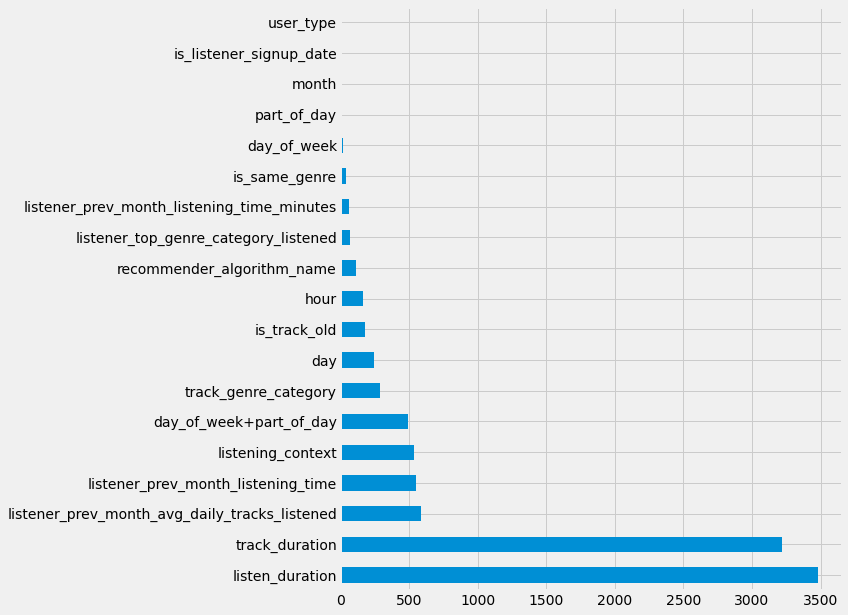

In [ ]:
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

### The Second Model

In [ ]:
class LGBM_r_GainFE(lgb.LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
    

In [ ]:
clf2 = LGBM_r_GainFE(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)


In [ ]:
clf2.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.992919
[200]	valid's auc: 0.995924
[300]	valid's auc: 0.997536
[400]	valid's auc: 0.998175
[500]	valid's auc: 0.998559
[600]	valid's auc: 0.998829
[700]	valid's auc: 0.998961
Early stopping, best iteration is:
[717]	valid's auc: 0.998986


LGBM_r_GainFE(colsample_bytree=0.9, metric='None', n_estimators=1000, n_jobs=4,
              num_leaves=15, random_state=314, subsample=0.9)

**Feature Importance**

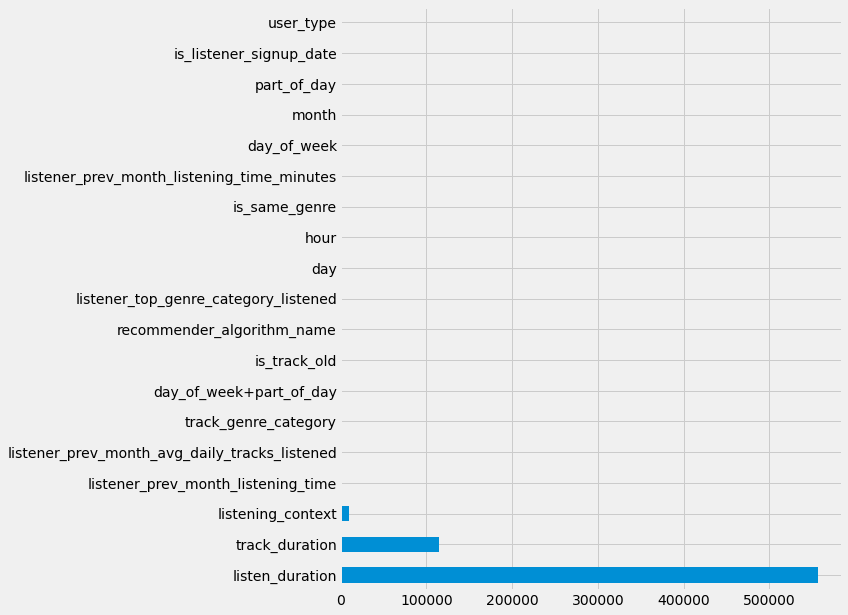

In [ ]:
feat_imp = pd.Series(clf2.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))


**Checking Feature Importance from Shap**

In [ ]:
shap.initjs()

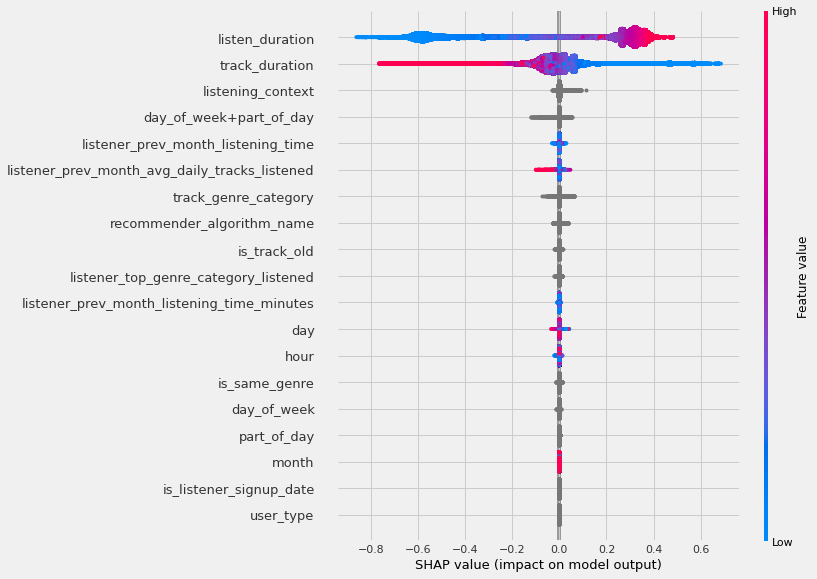

In [ ]:
shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

This graphs shows heavy listeners tend to listen more from recommended tracks

### The Third Model

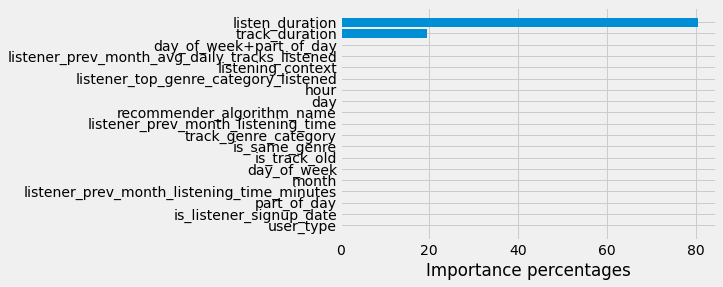

In [ ]:
model_3 = LGBMRegressor(importance_type='gain')
model_3.fit(X_train, y_train)

feature_importances = (model_3.feature_importances_ / sum(model_3.feature_importances_)) * 100

feature_names=X_train.columns
results = pd.DataFrame({'Features': feature_names,
                        'Importances': feature_importances})
results.sort_values(by='Importances', inplace=True)

ax = plt.barh(results['Features'], results['Importances'])
plt.xlabel('Importance percentages')
plt.show()


**Things to do improve lgbm's accurancy**

Use small num_leaves

Use min_data_in_leaf and min_sum_hessian_in_leaf

Use bagging by set bagging_fraction and bagging_freq

Use feature sub-sampling by set feature_fraction

Use bigger training data

Try lambda_l1, lambda_l2 and min_gain_to_split for regularization

Try max_depth to avoid growing deep tree

Try extra_trees

Try increasing path_smooth



### The Forth Model

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.928284


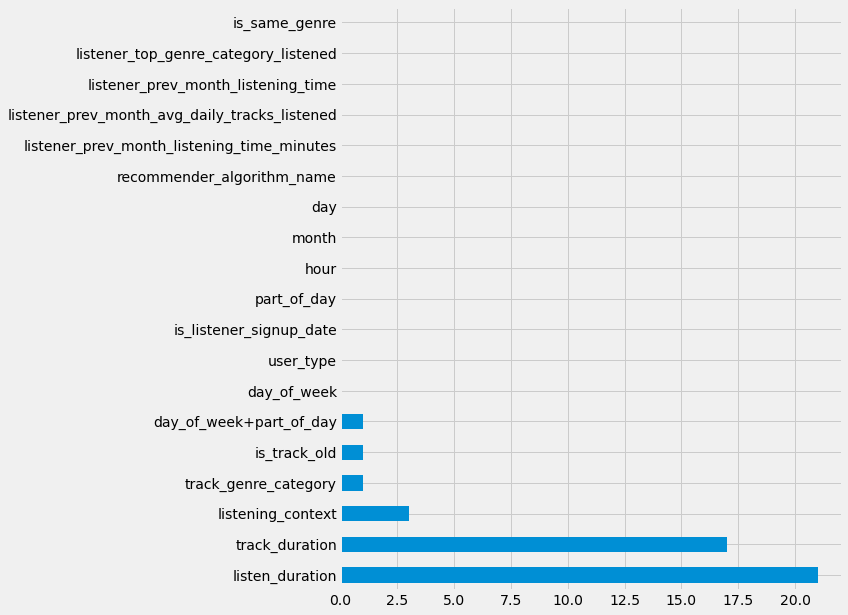

In [ ]:
clf_4 = lgb.LGBMRegressor(num_leaves= 12, max_depth=10, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=6, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.75,
                         learning_rate=0.09)


clf_4.fit(X_train, y_train, **fit_params)

feat_imp_4 = pd.Series(clf_4.feature_importances_, index=X.columns)
feat_imp_4.nlargest(30).plot(kind='barh', figsize=(8,10))

The newness of the tracks is a factor for user to skip a track

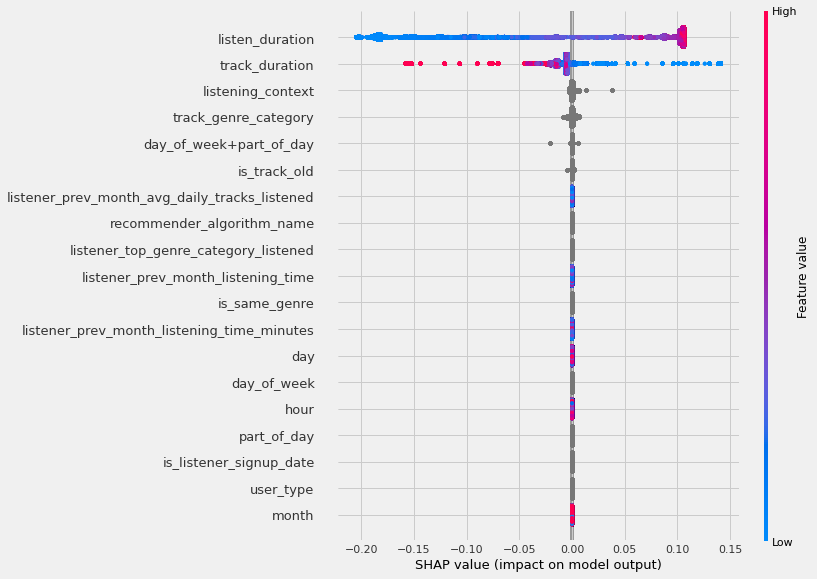

In [ ]:
shap_values_4 = shap.TreeExplainer(clf_4.booster_).shap_values(X_train)
shap.summary_plot(shap_values_4, X_train)